# Gaussian process regression (Kriging) vs Radial Basis Function interpolation

Reference : https://stackoverflow.com/questions/58895480/gaussian-process-regression-kriging-vs-radial-basis-function-interpolation

Goal : interpolation of temperature data between sensors over a floorplan.

In [1]:
import numpy as np
import openturns as ot
import pylab as pl

In [2]:
coordinates = ot.Sample(
    [
        [100.0, 100.0],
        [500.0, 100.0],
        [900.0, 100.0],
        [100.0, 350.0],
        [500.0, 350.0],
        [900.0, 350.0],
        [100.0, 600.0],
        [500.0, 600.0],
        [900.0, 600.0],
    ]
)
observations = ot.Sample([[x] for x in [25.0, 25.0, 10.0, 20.0, 25.0, 20.0, 15.0, 25.0, 25.0]])

In [3]:
# Extract coordinates
x = np.array(coordinates[:, 0])
y = np.array(coordinates[:, 1])

In [4]:
%matplotlib inline

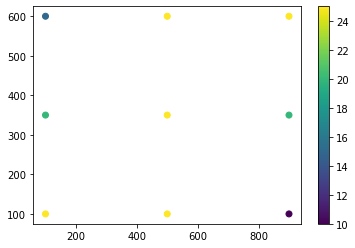

In [5]:
# Plot the data with a scatter plot and a color map

pl.scatter(x, y, c=observations, cmap="viridis")
pl.colorbar()

Fitting a kriging metamodel from this can be done with the following script. I used a squared exponential covariance model.

In [6]:
def fitKriging(coordinates, observations, covarianceModel, basis, set_bounds = False):
    """
    Fit the parameters of a kriging metamodel. 
    """
    algo = ot.KrigingAlgorithm(coordinates, observations, covarianceModel, basis)
    if set_bounds:
        scaleOptimizationBounds = ot.Interval(coordinates.getMin(), coordinates.getMax())
        algo.setOptimizationBounds(scaleOptimizationBounds)
    algo.run()
    krigingResult = algo.getResult()
    krigingMetamodel = krigingResult.getMetaModel()
    return krigingResult, krigingMetamodel

In [7]:
inputDimension = 2
basis = ot.ConstantBasisFactory(inputDimension).build()
covarianceModel = ot.SquaredExponential([1.0] * inputDimension, [1.0])
covarianceModel.setScale(coordinates.getMax())
krigingResult, krigingMetamodel = fitKriging(
    coordinates, observations, covarianceModel, basis, set_bounds=True
)

To plot the predictions from this kriging metamodel, I used the following script, based on the pcolor function.

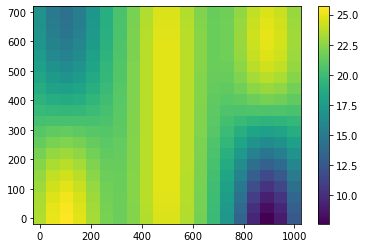

In [8]:
def plotKrigingPredictions(krigingMetamodel):
    """
    Plot the predictions of a kriging metamodel. 
    """
    # Create the mesh of the box [0.0, 1000.0] * [0.0, 700.0]
    myInterval = ot.Interval([0.0, 0.0], [1000.0, 700.0])
    # Define the number of interval in each direction of the box
    nx = 20
    ny = 20
    myIndices = [nx - 1, ny - 1]
    myMesher = ot.IntervalMesher(myIndices)
    myMeshBox = myMesher.build(myInterval)

    # Predict
    vertices = myMeshBox.getVertices()
    predictions = krigingMetamodel(vertices)

    # Format for plot
    X = np.array(vertices[:, 0]).reshape((ny, nx))
    Y = np.array(vertices[:, 1]).reshape((ny, nx))
    predictions_array = np.array(predictions).reshape((ny, nx))

    # Plot
    pl.pcolor(X, Y, predictions_array, shading = "auto")
    pl.colorbar()
    return


plotKrigingPredictions(krigingMetamodel)

You can see the same bands as in your predictions.

Looking at the covariance model explains why:

In [9]:
covarianceModel = krigingResult.getCovarianceModel()
covarianceModel

class=SquaredExponential scale=class=Point name=Unnamed dimension=2 values=[100,344.881] amplitude=class=Point name=Unnamed dimension=1 values=[6.75787]

The x-scale is 0.1672, which is much small than the y-scale 1.593. This is because we used an anisotropic covariance model, where the x-scale theta can be different from the y-scale theta.

In order to fix this, we could use an isotropic covariance model, where the x-scale is maintained equal to the y-scale. However, it is simpler just to set the x and y scales at a given value, and to estimate the amplitude parameter sigma only.

The following script set the scales to the mean of the previous estimate and estimates sigma only.

In [10]:
scales = covarianceModel.getScale()
meanScale = (scales[0] + scales[1]) / 2.0
covarianceModel.setScale([meanScale] * 2)
covarianceModel.setActiveParameter([2])  # Enable sigma (amplitude) only
# Learn amplitude only
krigingResult, krigingMetamodel = fitKriging(
    coordinates, observations, covarianceModel, basis, set_bounds = False
)
covarianceModel = krigingResult.getCovarianceModel()
covarianceModel

class=SquaredExponential scale=class=Point name=Unnamed dimension=2 values=[222.441,222.441] amplitude=class=Point name=Unnamed dimension=1 values=[5.72101]

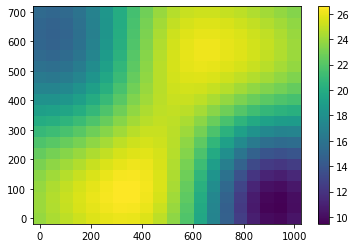

In [11]:
plotKrigingPredictions(krigingMetamodel)

Since the theta parameter is the same in both directions, the temperature is now spherical, as I guess you would expect it should be.